In [7]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [8]:
def create_piecewise_linear_paths_opt_times_smooth_pen(N, M, T, dt, V, J_V_init, J_V_final,mu_V_init, mu_V_final, num_control_points):
    # To do: documentation.
    """
    Constructs J/V and μ/V paths using piecewise linear interpolation with optimized control points.
    In addition to optimizing the intermediate control values, this function optimizes the intermediate times.
    
    The control points (for J/V, μ/V, and times) have fixed endpoints:
      t[0] = 0, t[-1] = T,
      J[0] = J_V_init, J[-1] = J_V_final,
      μ[0] = mu_V_init, μ[-1] = mu_V_final.
    
    The optimization variables are:
      - J_intermediate: control values for J/V (length = num_control_points - 2)
      - mu_intermediate: control values for μ/V (length = num_control_points - 2)
      - t_intermediate: control times (length = num_control_points - 2)
         (with constraints: 0 < t_1 < t_2 < ... < t_{N-2} < T)
    
    Returns:
      times_dense   : Dense time grid (from 0 to T with step dt).
      J_V_path      : Optimized J/V values evaluated on times_dense.
      mu_V_path     : Optimized μ/V values evaluated on times_dense.
      obj_value     : Final objective value (ground-state infidelity + penalty).
      opt_params    : Optimized parameter vector.
      t_control_opt : Optimized full control times (with endpoints).
      J_control_opt : Optimized full control J/V values (with endpoints).
      mu_control_opt: Optimized full control μ/V values (with endpoints).
    """
    # Create a dense time grid for evaluation.
    times_dense = np.arange(0, T + dt, dt)
    
    # Total number of control points.
    n_points = num_control_points
    n_int = n_points - 2  # number of intermediate (free) control points

    # Initial guesses for the intermediate control values (linearly spaced between endpoints).
    J_initial_guess = np.linspace(J_V_init, J_V_final, n_points)[1:-1]
    mu_initial_guess = np.linspace(mu_V_init, mu_V_final, n_points)[1:-1]
    # Initial guess for the intermediate times: linearly spaced between 0 and T.
    t_initial_guess = np.linspace(0, T, n_points)[1:-1]

    # Combine into a single vector: first J, then mu, then times.
    x0 = np.concatenate((J_initial_guess, mu_initial_guess, t_initial_guess))
    
    # A small buffer to ensure strict ordering of times.
    eps = 1e-3

    # Define constraints for the times portion.
    # We require:
    #   t_intermediate[0] >= eps,
    #   t_intermediate[i] - t_intermediate[i-1] >= eps for i=1,...,n_int-1,
    #   T - t_intermediate[-1] >= eps.
    cons = []
    # Constraint for first intermediate time:
    cons.append({'type': 'ineq', 'fun': lambda x: x[2*n_int] - eps})
    # Constraints for ordering among intermediate times:
    for i in range(1, n_int):
        cons.append({
            'type': 'ineq',
            'fun': lambda x, i=i: x[2*n_int + i] - x[2*n_int + i - 1] - eps
        })
    # Constraint for last intermediate time:
    cons.append({'type': 'ineq', 'fun': lambda x: T - x[2*n_int + n_int - 1] - eps})

    # Objective function: compute the piecewise linear paths,
    # build Hamiltonians at each dense time, simulate time evolution,
    # and return the ground-state infidelity plus a penalty for negative μ/V.
    def objective(x):
        # Unpack the optimization vector.
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]
        
        # Construct full control arrays (with endpoints fixed).
        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))
        
        # Build the dense paths via linear interpolation.
        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)
        
        # Add a penalty if μ/V becomes negative anywhere.
        penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        
        # Build Hamiltonians at each dense time.
        hamiltonians = []
        for i, t in enumerate(times_dense):
            ham = construct_rescaled_hamiltonian(N, M, V,
                                                 mu_V_ratio=mu_path_dense[i],
                                                 J_V_ratio=J_path_dense[i])
            hamiltonians.append(ham)
        
        # Simulate time evolution.
        energies, _, state_probabilities, _, _ = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        ground_state_fidelity = state_probabilities[-1, 0]
        ground_state_infidelity = 1 - ground_state_fidelity
        
        return ground_state_infidelity + penalty
    
    def smooth_objective(x):
        # Unpack the optimization vector.
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]
        
        # Construct full control arrays (with endpoints fixed).
        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))
        
        # Build the dense paths via linear interpolation.
        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)
        
        # Existing penalty for negative μ/V.
        penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        
        # --- NEW: Smoothness penalties to discourage windy paths ---
        lambda_smooth_J = 0.01  # Tune these values as needed.
        lambda_smooth_mu = 0.01
        smoothness_penalty_J = lambda_smooth_J * np.sum(np.diff(J_control, 2)**2)
        smoothness_penalty_mu = lambda_smooth_mu * np.sum(np.diff(mu_control, 2)**2)
        smoothness_penalty = smoothness_penalty_J + smoothness_penalty_mu
        # --- END NEW ---
        
        # Build Hamiltonians at each dense time.
        hamiltonians = []
        for i, t in enumerate(times_dense):
            ham = construct_rescaled_hamiltonian(N, M, V,
                                                mu_V_ratio=mu_path_dense[i],
                                                J_V_ratio=J_path_dense[i])
            hamiltonians.append(ham)
        
        # Simulate time evolution.
        energies, _, state_probabilities, _, _ = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        ground_state_fidelity = state_probabilities[-1, 0]
        ground_state_infidelity = 1 - ground_state_fidelity
    
        return ground_state_infidelity + penalty + smoothness_penalty


    # Run the optimization with SLSQP so that constraints can be enforced.
    result = minimize(smooth_objective, x0, method='SLSQP', constraints=cons)
    opt_params = result.x

    # Extract optimized intermediate values.
    J_int_opt = opt_params[:n_int]
    mu_int_opt = opt_params[n_int:2*n_int]
    t_int_opt = opt_params[2*n_int:3*n_int]

    # Construct full control arrays.
    J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
    mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
    t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

    # Compute the dense paths with the optimized control points.
    J_V_path = np.interp(times_dense, t_control_opt, J_control_opt)
    mu_V_path = np.interp(times_dense, t_control_opt, mu_control_opt)
    
    obj_value = result.fun
    return (times_dense, J_V_path, mu_V_path, obj_value, opt_params,
            t_control_opt, J_control_opt, mu_control_opt)

In [9]:
def create_piecewise_linear_paths_opt_times_ad_pen(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points):
    """
    Constructs optimized J/V and μ/V paths using piecewise linear interpolation,
    while optimizing both the intermediate control values and the intermediate times.
    An adiabaticity penalty is added to the objective to discourage rapid changes.
    
    Returns:
      times_dense   : Dense time grid.
      J_V_path      : Optimized J/V path on the dense grid.
      mu_V_path     : Optimized μ/V path on the dense grid.
      obj_value     : Final objective value.
      opt_params    : Optimized parameter vector.
      t_control_opt : Full optimized control times (with endpoints).
      J_control_opt : Full optimized J/V control values.
      mu_control_opt: Full optimized μ/V control values.
    """
    # Dense time grid for evaluation.
    times_dense = np.arange(0, T + dt, dt)
    
    # Number of control points and number of free (intermediate) points.
    n_points = num_control_points
    n_int = n_points - 2

    # Initial guesses for the control values (linearly spaced between endpoints).
    J_initial_guess = np.linspace(J_V_init, J_V_final, n_points)[1:-1]
    mu_initial_guess = np.linspace(mu_V_init, mu_V_final, n_points)[1:-1]
    # Initial guess for intermediate times (linearly spaced between 0 and T).
    t_initial_guess = np.linspace(0, T, n_points)[1:-1]

    # Combine into one vector: [J_intermediate, mu_intermediate, t_intermediate].
    x0 = np.concatenate((J_initial_guess, mu_initial_guess, t_initial_guess))
    
    # A small buffer to ensure strict ordering for times.
    eps = 1e-3

    # Constraints for the intermediate times: ensure they lie strictly between 0 and T and are ordered.
    cons = []
    cons.append({'type': 'ineq', 'fun': lambda x: x[2*n_int] - eps})
    for i in range(1, n_int):
        cons.append({
            'type': 'ineq',
            'fun': lambda x, i=i: x[2*n_int + i] - x[2*n_int + i - 1] - eps
        })
    cons.append({'type': 'ineq', 'fun': lambda x: T - x[2*n_int + n_int - 1] - eps})
    
    # Weights for additional penalties.
    lambda_ad = 0.01       # Adiabaticity penalty weight.
    lambda_smooth_J = 0.01 # Smoothness penalty for J/V.
    lambda_smooth_mu = 0.01# Smoothness penalty for μ/V.
    
    def objective(x):
        # Unpack the optimization vector.
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]
        
        # Reconstruct full control arrays (with endpoints fixed).
        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))
        
        # Build dense paths via linear interpolation.
        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)
        
        # Penalty for negative μ/V values.
        penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        
        # Smoothness penalty (using discrete second differences).
        smoothness_penalty_J = lambda_smooth_J * np.sum(np.diff(J_control, 2)**2)
        smoothness_penalty_mu = lambda_smooth_mu * np.sum(np.diff(mu_control, 2)**2)
        smoothness_penalty = smoothness_penalty_J + smoothness_penalty_mu
        
        # Build Hamiltonians at each dense time.
        hamiltonians = []
        for i, t in enumerate(times_dense):
            ham = construct_rescaled_hamiltonian(N, M, V,
                                                 mu_V_ratio=mu_path_dense[i],
                                                 J_V_ratio=J_path_dense[i])
            hamiltonians.append(ham)
        
        # --- Adiabaticity Penalty ---
        adiabatic_penalty = 0.0
        for i in range(len(times_dense) - 1):
            # Finite difference approximation of the derivative of H (using differences of control values).
            dJ = J_path_dense[i+1] - J_path_dense[i]
            dmu = mu_path_dense[i+1] - mu_path_dense[i]
            dH_norm = np.sqrt(dJ**2 + dmu**2)
            # Use the computed gap from the Hamiltonian at time i.
            
            energies, _ = exact_diagonalize(hamiltonians[i])
            gap = energies[1] - energies[0]
            adiabatic_penalty += (dH_norm**2 / gap**2) * (times_dense[i+1] - times_dense[i])
        adiabatic_penalty *= lambda_ad
        
        # Simulate time evolution.
        energies, _, state_probabilities, _, _ = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        ground_state_fidelity = state_probabilities[-1, 0]
        ground_state_infidelity = 1 - ground_state_fidelity
        
        return ground_state_infidelity + penalty + smoothness_penalty + adiabatic_penalty

    # Run the optimization using SLSQP to enforce constraints.
    result = minimize(objective, x0, method='SLSQP', constraints=cons)
    opt_params = result.x

    # Extract optimized intermediate values.
    J_int_opt = opt_params[:n_int]
    mu_int_opt = opt_params[n_int:2*n_int]
    t_int_opt = opt_params[2*n_int:3*n_int]

    # Construct full control arrays.
    J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
    mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
    t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

    # Generate the dense paths with the optimized control points.
    J_V_path = np.interp(times_dense, t_control_opt, J_control_opt)
    mu_V_path = np.interp(times_dense, t_control_opt, mu_control_opt)
    
    obj_value = result.fun
    return (times_dense, J_V_path, mu_V_path, obj_value, opt_params,
            t_control_opt, J_control_opt, mu_control_opt)

Final Fidelity (1 - (infidelity + penalty)): 0.3283882285265194
Optimized parameters (J_int, μ_int, t_int): [-1.68174377 -1.35118596  0.49315614  1.18826512  1.25792221  0.30458958
  8.87873631  7.22021323  4.99614666  2.90900148  1.38790883  1.5040915
  0.0422832   1.00002024  1.00102024  1.97319838  2.12672673  4.90872348]


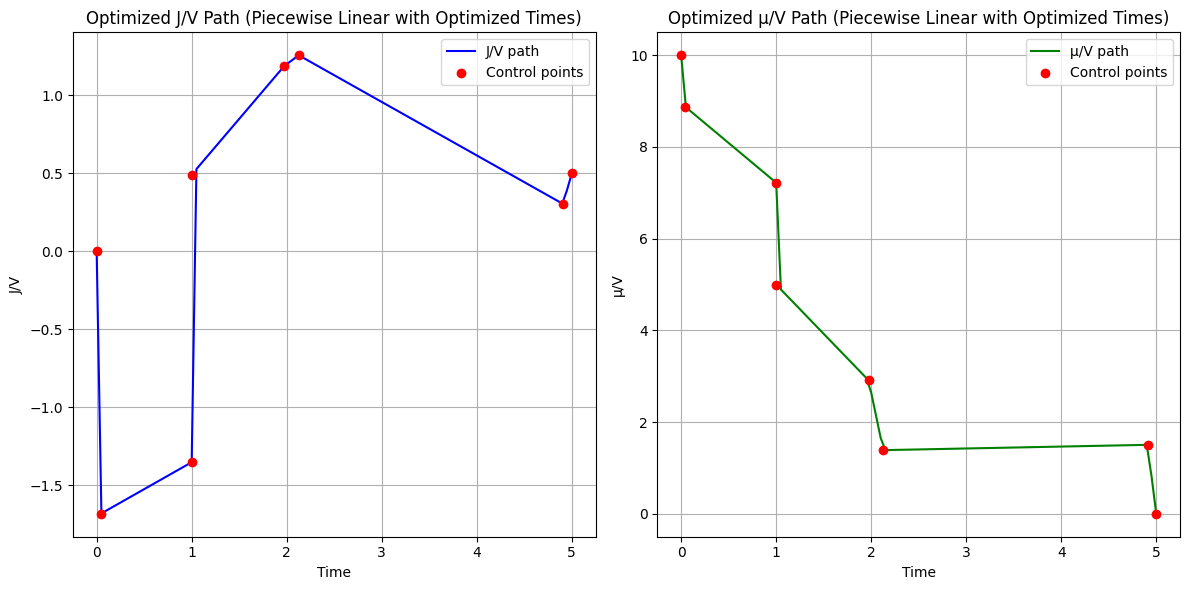

In [10]:
# --- Set up problem parameters ---
N = 3
M = 2
V = 1
T = 5
dt = 0.05

J_V_init = 0
J_V_final = 0.5
mu_V_init = 10
mu_V_final = 0

num_control_points = 8  # Total control nodes (including endpoints)

# --- Run the optimization ---
(times_dense, J_V_path, mu_V_path, obj_value, opt_params,
 t_control_opt, J_control_opt, mu_control_opt) = create_piecewise_linear_paths_opt_times_smooth_pen(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points)

print("Final Fidelity (1 - (infidelity + penalty)):", 1-obj_value)
print("Optimized parameters (J_int, μ_int, t_int):", opt_params)

# --- Plot the optimized paths along with control points ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(times_dense, J_V_path, label="J/V path", color="blue")
plt.scatter(t_control_opt, J_control_opt, color="red", zorder=5, label="Control points")
plt.xlabel("Time")
plt.ylabel("J/V")
plt.title("Optimized J/V Path (Piecewise Linear with Optimized Times)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(times_dense, mu_V_path, label="μ/V path", color="green")
plt.scatter(t_control_opt, mu_control_opt, color="red", zorder=5, label="Control points")
plt.xlabel("Time")
plt.ylabel("μ/V")
plt.title("Optimized μ/V Path (Piecewise Linear with Optimized Times)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

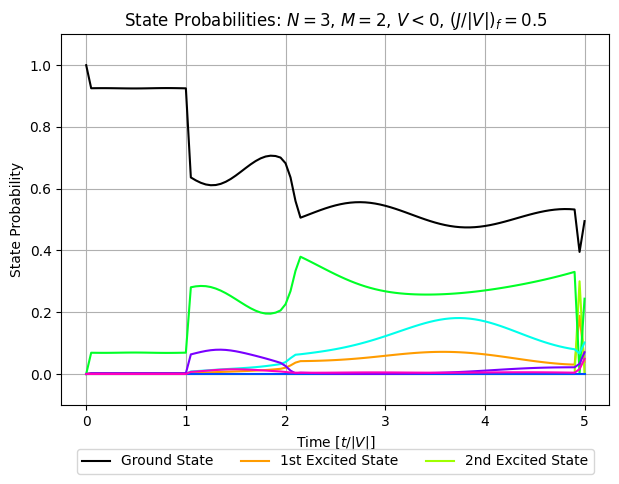

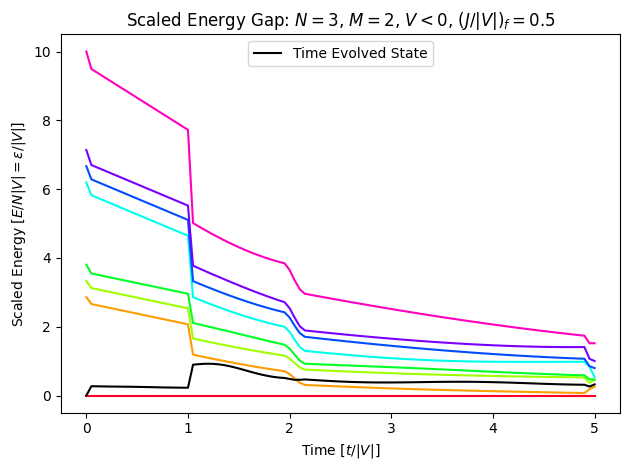

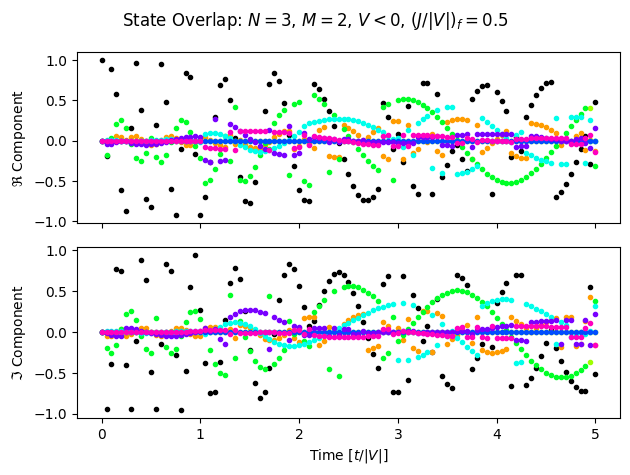

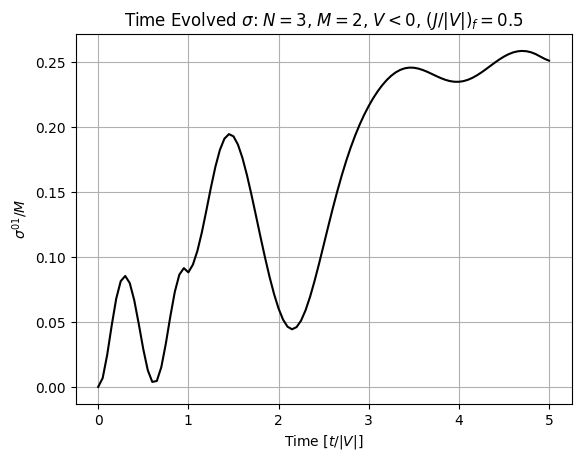

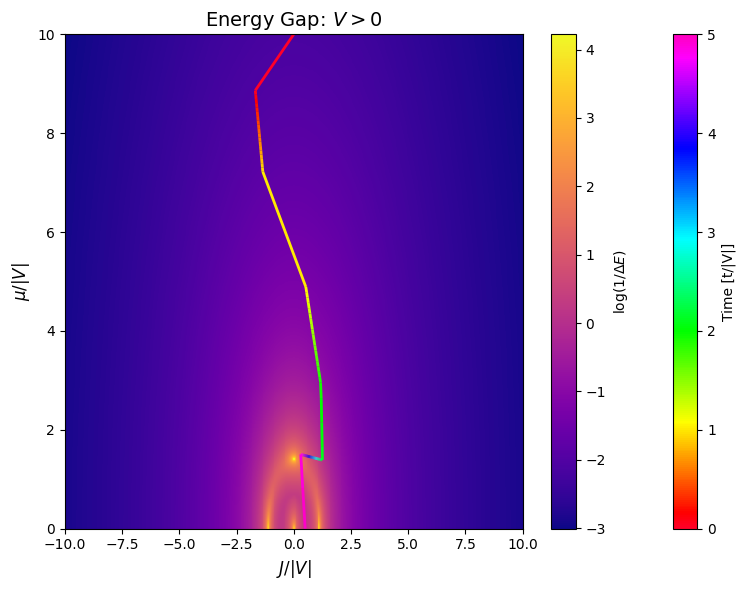

In [11]:
hamiltonians = []
for i, t in enumerate(times_dense):
    ham = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i],J_V_ratio=J_V_path[i])
    hamiltonians.append(ham)

results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
plot_time_evolution(N, M, results, times_dense, J_V_ratios = J_V_path, mu_V_ratios = mu_V_path)

if np.sign(V) > 0:
    plot_data(N, M, sign_V="positive", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path, J_V_ratios = J_V_path, times = times_dense)
else:
    plot_data(N, M, sign_V="negative", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path, J_V_ratios = J_V_path, times = times_dense)

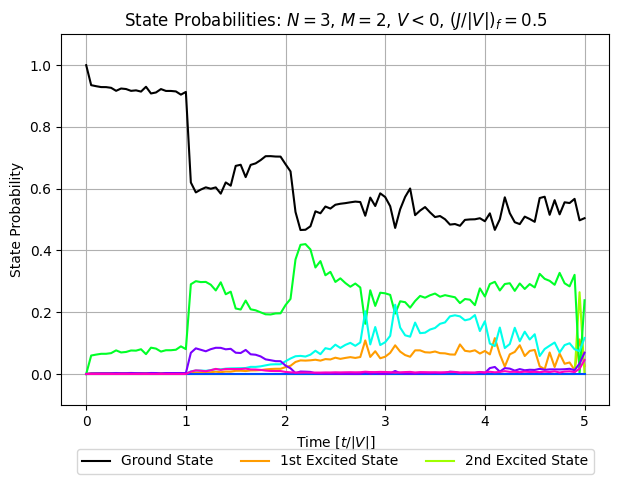

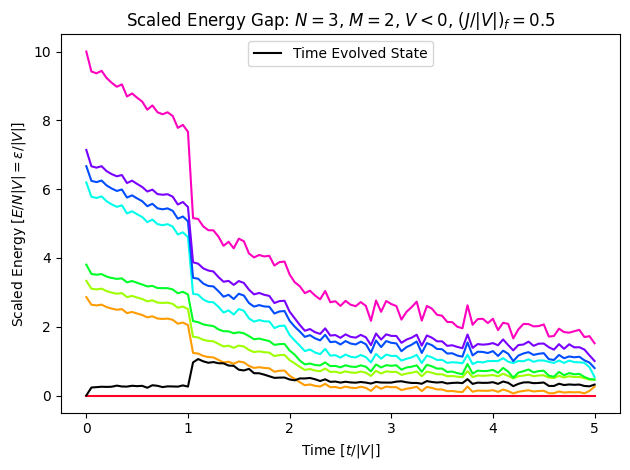

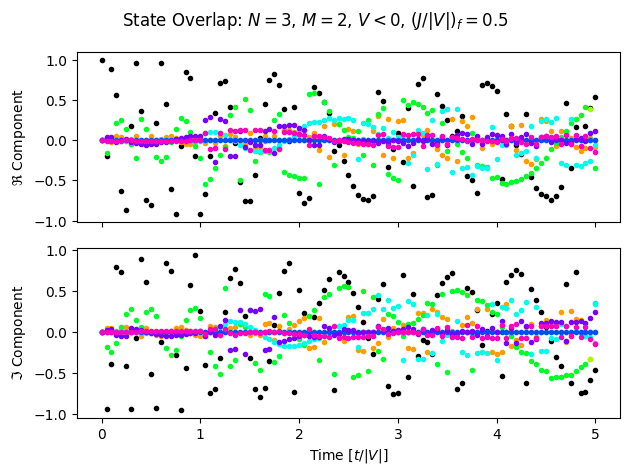

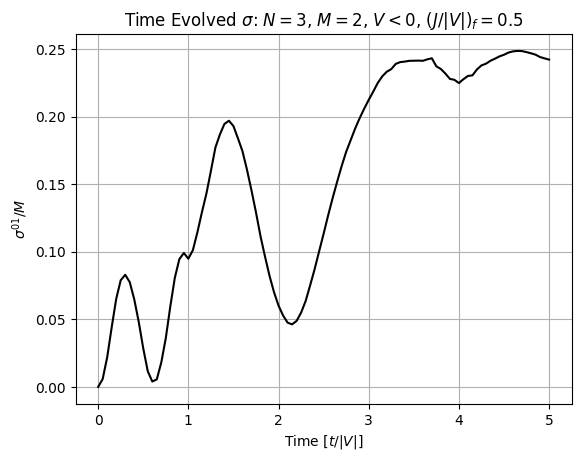

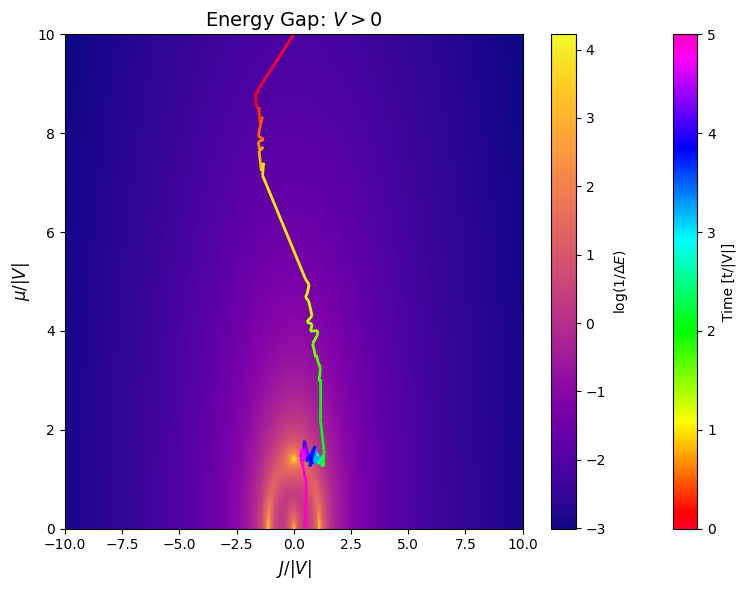

In [12]:
# Example ideal paths from your optimization (arrays of same length as times_dense):
# times_dense, J_V_path, mu_V_path

def add_noise_to_path(path, noise_strength):
    """
    Adds Gaussian noise to the interior of the given path, leaving the first and last points unchanged.
    """
    noisy_path = path.copy()
    if len(path) > 2:
        noise = np.random.normal(0, noise_strength, size=path[1:-1].shape)
        noisy_path[1:-1] += noise
    return noisy_path

noise_strength = 0.1

J_V_path_noisy = add_noise_to_path(J_V_path, noise_strength)
mu_V_path_noisy = add_noise_to_path(mu_V_path, noise_strength)

noisy_hamiltonians = []
for i, t in enumerate(times_dense):
    ham = construct_rescaled_hamiltonian(N, M, V,
                                         mu_V_ratio=mu_V_path_noisy[i],
                                         J_V_ratio=J_V_path_noisy[i])
    noisy_hamiltonians.append(ham)

results = simulate_hamiltonian_time_evolution(noisy_hamiltonians, times_dense)
plot_time_evolution(N, M, results, times_dense, J_V_ratios=J_V_path_noisy, mu_V_ratios=mu_V_path_noisy)

if np.sign(V) > 0:
    plot_data(N, M, sign_V="positive", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path_noisy, J_V_ratios = J_V_path_noisy, times = times_dense)
else:
    plot_data(N, M, sign_V="negative", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path_noisy, J_V_ratios = J_V_path_noisy, times = times_dense)